Compare BP marginals with montecarlo on a tree

In [2]:
import Pkg; Pkg.activate("..")

  Activating project at `~/MatrixProductBP`


In [ ]:
using MatrixProductBP, MatrixProductBP.Models
using Graphs, Plots, Printf, IndexedGraphs, Statistics
using Base.Threads
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear);

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [ ]:
T = 5
N = 15
k = 4
gg = random_regular_graph(N, k)
t = SimpleGraph(prim_mst(gg))
g = IndexedGraph(t)
@assert !is_cyclic(g)
@assert is_connected(g)
λ = 0.2
ρ = 0.1
γ = 3/N
nobs = N÷2;

In [ ]:
function kl_marginals_bp_bondsize(T::Integer, N::Integer, k::Integer, λ::Real, ρ::Real, γ::Real, 
        nobs::Integer, bonddims::AbstractVector{Int}; 
        ns_mc = 5*10^6, require_convergence=true, maxiter=100, tol=1e-3, kw...)
    
    b_bp = [Vector{Vector{Float64}}[] for _ in bonddims]
    
    gg = random_regular_graph(N, k)
    t = SimpleGraph(prim_mst(gg))
    g = IndexedGraph(t)
    @assert !is_cyclic(g)
    
    sis = SIS(g, λ, ρ, T; γ)
    bp = mpbp(deepcopy(sis), d=1)
    cb = CB_BP(bp)
    x = draw_node_observations!(bp, nobs; last_time=true, softinf=1e2)
    sms = sample(bp, ns_mc)
    b_mc_ = marginals(sms)
    b_mc = [[getproperty.(p, :val) for p in bi] for bi in b_mc_]
    
    for j in eachindex(bonddims)
        svd_trunc = TruncBond(bonddims[j])
        reset_messages!(bp)
        cb = CB_BP(bp; showprogress=false)
        iters, ε = iterate!(bp; maxiter, svd_trunc, cb, tol)
        if require_convergence
            iters == maxiter && error("BP did not converge")
        end
        b_bp[j] = beliefs(bp)
    end
    kls = [kl_marginals(b, b_mc) for b in b_bp]
end

In [ ]:
bonddims = [2, 3, 6];

In [ ]:
kls_bp = Vector{Vector{Float64}}[];

In [20]:
ninstances = 20
kls_bp_ = [[zeros(T+1) for _ in bonddims] for _ in 1:ninstances]
@threads for n in 1:ninstances
#     println("### instance $n of $ninstances")
    kls_bp_[n] = kl_marginals_bp_bondsize(T, N, k, λ, ρ, γ, nobs, bonddims, ns_mc=10^6)
end
append!(kls_bp, kls_bp_);

SoftMargin sampling 100%|████████████████████████████████| Time: 0:03:19SoftMargin sampling  99%|███████████████████████████████▊|  ETA: 0:00:02SoftMargin sampling  59%|██████████████████▉             |  ETA: 0:01:57SoftMargin sampling  58%|██████████████████▋             |  ETA: 0:02:01SoftMargin sampling  26%|████████▎                       |  ETA: 0:05:34SoftMargin sampling  26%|████████▌                       |  ETA: 0:05:22SoftMargin sampling  26%|████████▎                       |  ETA: 0:05:32SoftMargin sampling  25%|████████▏                       |  ETA: 0:05:40SoftMargin sampling  27%|████████▌                       |  ETA: 0:05:18SoftMargin sampling  25%|████████                        |  ETA: 0:05:50SoftMargin sampling  27%|████████▌                       |  ETA: 0:05:20SoftMargin sampling  26%|████████▎                       |  ETA: 0:05:32SoftMargin sampling  27%|████████▊                       |  ETA: 0:05:10SoftMargin sampling  26%|████████▎                       |  ETA:

In [21]:
kls_bp_avg = map(eachindex(bonddims)) do i
    mean([a[i] for a in kls_bp])
end
kls_bp_std = map(eachindex(bonddims)) do i
    std([a[i] for a in kls_bp]) ./ sqrt(length(kls_bp))
end; 

SIS with: P(S→I)=λ=0.2, P(I→S)=ρ=0.1. P(zero patient)=γ=0.2
Random regular N=15, k=4. T=5, 7 random observations from the prior at final time
Average over 80 random instances.


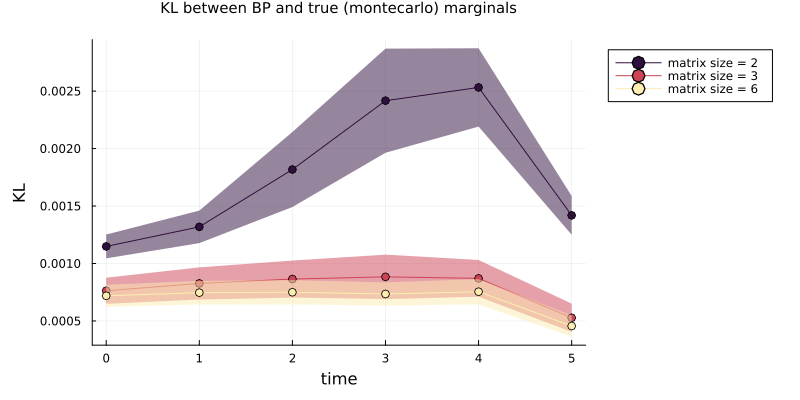

In [22]:
println("SIS with: P(S→I)=λ=$λ, P(I→S)=ρ=$ρ. P(zero patient)=γ=$γ")
println("Random regular N=$N, k=$k. T=$T, $nobs random observations from the prior at final time")
println("Average over ", length(kls_bp), " random instances.")
using ColorSchemes
cg = cgrad(:matter, length(bonddims), categorical=true) |> reverse
pl = plot(xlabel="time", ylabel="KL", xticks=0:T, legend=:bottomright)
for i in eachindex(bonddims)
    plot!(pl, 0:T, kls_bp_avg[i], ribbon=kls_bp_std[i], c=cg[i],
        label="matrix size = $(bonddims[i])", m=:o)
end
plot(pl, title="KL between BP and true (montecarlo) marginals", titlefontsize=10, 
    legend=:outertopright, size=(800,400), margin=5Plots.mm)